## Dog Vs Cat: A CNN based Dog/Cat Classifer 

# enviroment setup

In [33]:
import numpy as np
import os
import glob
import cv2
from collections import Counter
import random

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dropout, ELU
from keras.layers.convolutional import Cropping2D, Convolution2D, MaxPooling2D
from keras.layers.core import Lambda, Dense, Activation, Flatten
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

TRAIN_DATA_PATH_LIST = ["./train"]
TEST_DATA_PATH_LIST = ["./test"]

IMAGE_INPUT_SHAPE = (224, 224, 3)

LABEL_LIST = sorted(["dog", "cat"])

DO_VISUALIZE = True
RUN_HOMEBREW_MODEL = False

# loading, analysis and encoding data

one hot encoding:  {'dog': array([ 0.,  1.]), 'cat': array([ 1.,  0.])}
loading data from: ./train
total 12500 dog images loaded.
total 12500 cat images loaded.
total 25000 raw data samples loaded.
{(0.0, 1.0): 'dog', (1.0, 0.0): 'cat'}
most common dog image height:  [(374, 1400), (375, 1345), (500, 1040), (499, 993), (332, 153), (333, 152), (399, 150), (299, 130), (240, 123), (300, 122)]
most common dog image width:  [(500, 2486), (499, 2398), (350, 197), (400, 194), (399, 175), (375, 174), (299, 162), (319, 160), (320, 155), (300, 146)]
most common cat image height:  [(374, 1684), (375, 1614), (499, 846), (500, 804), (333, 166), (332, 155), (239, 149), (240, 130), (299, 108), (359, 89)]
most common cat image width:  [(499, 2914), (500, 2859), (349, 188), (300, 181), (350, 175), (319, 165), (320, 164), (299, 149), (399, 149), (400, 142)]


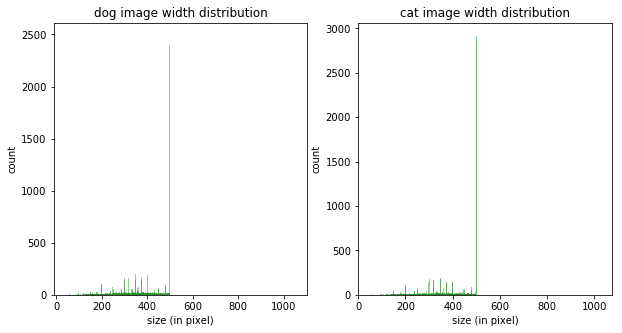

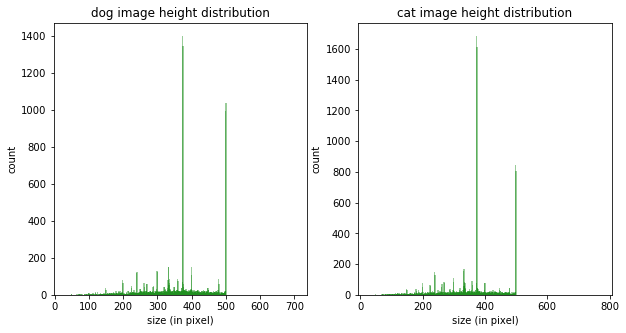

In [6]:
def label_one_hot_encoding(labe_list):
    encoder = LabelEncoder()
    transfomed_label = encoder.fit_transform(labe_list)
    one_hot_encoded_labels =  np_utils.to_categorical(transfomed_label)
    one_hot_label_dict = {}
    for i  in range(len(labe_list)):
        one_hot_label_dict[labe_list[i]] = one_hot_encoded_labels[i] 
    
    print("one hot encoding: ", one_hot_label_dict)
    return one_hot_label_dict
    



def load_samples(DATA_PATH, one_hot_encoding_dict):
    labels = one_hot_encoding_dict.keys()    
    samples = [] # [one_hot_label, image_path]
    temp_size = 0
    for dir in DATA_PATH: 
        print("loading data from: " + dir)
        for key in labels:           
            samples += [[one_hot_encoding_dict[key],file] for file in glob.glob(os.path.join(dir, key + '*.jpg'))]
            temp_size = len(samples) - temp_size    
            print("total " + str(temp_size) + " " + key + " images loaded.")
            temp_size = len(samples)
        
        print("total " + str(temp_size) + " raw data samples loaded.")
        
    return samples    



def raw_data_analysis(raw_sample_list, one_hot_encoding_dict):
    
    inverse_one_hot_encoding_dict = {tuple(v): k for k, v in one_hot_encoding_dict.items()}
    
    print(inverse_one_hot_encoding_dict)
    
    image_size_counter = {}   
    dimension_shape = ["height", "width"]
    
    for sample in raw_sample_list:   
        label = inverse_one_hot_encoding_dict[tuple(sample[0])]
        if label  not in image_size_counter:
            image_size_counter[label]= {}
            for i in range(len(dimension_shape)):
                image_size_counter[label][dimension_shape[i]] = Counter() 
        
        img = cv2.imread(sample[1])
        for i in range(len(dimension_shape)):
            image_size_counter[label][dimension_shape[i]][img.shape[i]] += 1

            
    for label in image_size_counter.keys():
        for dim in dimension_shape:
             print("most common " + label + " image " + dim + ": " , image_size_counter[label][dim].most_common(10))
            

    return image_size_counter



def visualize_image_size_distribution(counter_dict):
    data_label_list = list(counter_dict.keys())
    dimension_list =   list(counter_dict[data_label_list[0]].keys())   
    for dimension in dimension_list:    
        f, ax = plt.subplots(1, 2)
        for i in range(len(data_label_list)):
            x = sorted(counter_dict[data_label_list[i]][dimension].keys())
            y = [counter_dict[data_label_list[i]][dimension][j] for j in x]
            ax[i].bar(x, y, width = 4, align='center', color= "green", alpha=0.4)            
            ax[i].set_title(data_label_list[i] + " image " + dimension + " distribution")
            ax[i].set_xlabel("size (in pixel)")
            ax[i].set_ylabel("count")
        plt.show()
        


    
one_hot_encoding_dict = label_one_hot_encoding(LABEL_LIST)
raw_samples = load_samples(TRAIN_DATA_PATH_LIST, one_hot_encoding_dict)
image_shape_counter = raw_data_analysis(raw_samples, one_hot_encoding_dict)
visualize_image_size_distribution(image_shape_counter)





## resize helper function

In [13]:
def resize_image(image, output_shape = (100, 100, 3)):
    shape = (output_shape[0], output_shape[1])    
    resized_image = cv2.resize(image, shape)
    return resized_image


    

    

## setup model from scratch

In [23]:
def base_model_setup(input_shape, num_classes):
    model = Sequential()
    
    
    model.add(Lambda(lambda x: x/127.5 -1., input_shape = input_shape))
    model.add(Convolution2D(32,3,3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Convolution2D(32,3,3))    
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Convolution2D(64,3,3))    
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))    
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))    
    model.add(Dense(num_classes))
    print(model.summary())
    return model
       

#model_flow_setup(input_shape = (224, 224, 3) , num_classes = 2)    
        

def create_homebrew_models(input_shape = (224, 224, 3), num_classes = 2, output_activation_list = ['sigmoid'] , loss_function_list = ['categorical_crossentropy'], optimizer_list = ["rmsprop", "adam"]):
    model_dict = {}
    for loss_function in loss_function_list:
        for optimizer in optimizer_list:
            for output_activation in output_activation_list:
                model = base_model_setup(input_shape, num_classes)
                model.add(Activation(output_activation))
                
                model.compile(loss = loss_function,  optimizer = optimizer , metrics = ['accuracy'])
                name = "activation=" + output_activation + "_loss=" + loss_function + "_optimizer=" + optimizer
                print("model generation: " + name)
                print(model.summary())
                model_dict[name] = model
    
    return model_dict    
    
    
home_brew_model_dict = create_homebrew_models(input_shape = (224, 224, 3), num_classes = 2, output_activation_list = ['sigmoid', 'softmax'] , loss_function_list = ['categorical_crossentropy' ], optimizer_list = ["rmsprop", "adam"])    
    

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 224, 224, 3)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 222, 222, 32)  896         lambda_2[0][0]                   
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 222, 222, 32)  0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 111, 111, 32)  0           activation_5[0][0]               
___________________________________________________________________________________________

## setup model:  stand on the shoulders of giants

In [26]:
def fine_tune_pretrained_model(input_shape = (224, 224, 3) , num_classes = 2, pre_trained_model_list = ["ResNet"]):
    model_dict = {}
    
    for model_type in pre_trained_model_list:
        if model_type == "ResNet":
            pre_trained_model = ResNet50(weights='imagenet', input_shape = input_shape, include_top = False)
        elif model_type == "VGG19":
            pre_trained_model = VGG19(weights='imagenet', input_shape = input_shape, include_top=False)
        elif model_type == "VGG16":
            pre_trained_model = VGG19(weights='imagenet', input_shape = input_shape, include_top=False)
    
        print("load pre-trainned model weight: " + model_type)
        
        for layer in pre_trained_model.layers:
            layer.trainable = False  # freeze the front-end weight of pre-trained model weight
        
        #pre_trained_model.summary()    
        
        # add back-end for current problem 
        x = pre_trained_model.output       
        x = Flatten(name='flatten')(x)        
        x = Dense(256, activation = "relu", name="fc256") (x)        
        x = Dense(64, activation = "relu", name="fc64") (x)
        x = Dropout(0.5) (x)    
        x = Dense(num_classes, name="fc_output") (x)
        predictions =  Activation('softmax') (x)
        
        model = Model(input = pre_trained_model.input,  output=predictions)
        model.compile(loss = 'categorical_crossentropy',  optimizer = "rmsprop" , metrics = ['accuracy'])
        print(model_type)
        print(model.summary())
        model_dict[model_type] = model
    
    return model_dict


fine_tune_pretrained_model_dict =  fine_tune_pretrained_model(num_classes = 2, pre_trained_model_list = ["VGG16","VGG19","ResNet"])

load pre-trainned model weight: VGG16
VGG16
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
_______________________________________________

## image generator for model training and testing 

(224, 224, 3)


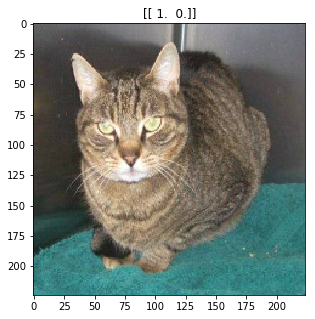

In [19]:
def sample_generator(samples, batch_size=10):
    
    while True:
        samples = shuffle(samples)
        num_samples = len(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]
            images = []
            one_hot_labels = []
            
            for sample in batch_samples:
                image = cv2.imread(sample[1])
                image = resize_image(image, output_shape = IMAGE_INPUT_SHAPE)

                images.append(image)
                one_hot_labels.append(sample[0])
                #plt.imshow(image)
                #plt.show()
            
            X_train = np.array(images)
            y_train = np.array(one_hot_labels)
            
            #print("y_train", y_train)
            yield shuffle(X_train, y_train)

    
# generator unit test
test_x, test_y = next(sample_generator(raw_samples, batch_size = 1))
test_x = np.squeeze(test_x)
print(test_x.shape)
plt.imshow(cv2.cvtColor(test_x, cv2.COLOR_BGR2RGB))
plt.title(str(test_y))

## model training flow setup

one hot encoding:  {'dog': array([ 0.,  1.]), 'cat': array([ 1.,  0.])}
label encoding is done.
loading data from: ./train
total 12500 dog images loaded.
total 12500 cat images loaded.
total 25000 raw data samples loaded.
raw sample loaded.
{(0.0, 1.0): 'dog', (1.0, 0.0): 'cat'}
most common dog image height:  [(374, 1400), (375, 1345), (500, 1040), (499, 993), (332, 153), (333, 152), (399, 150), (299, 130), (240, 123), (300, 122)]
most common dog image width:  [(500, 2486), (499, 2398), (350, 197), (400, 194), (399, 175), (375, 174), (299, 162), (319, 160), (320, 155), (300, 146)]
most common cat image height:  [(374, 1684), (375, 1614), (499, 846), (500, 804), (333, 166), (332, 155), (239, 149), (240, 130), (299, 108), (359, 89)]
most common cat image width:  [(499, 2914), (500, 2859), (349, 188), (300, 181), (350, 175), (319, 165), (320, 164), (299, 149), (399, 149), (400, 142)]


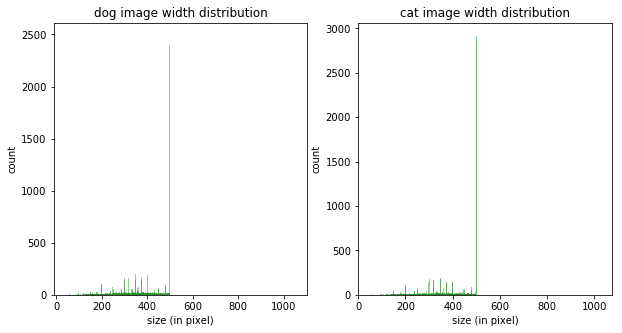

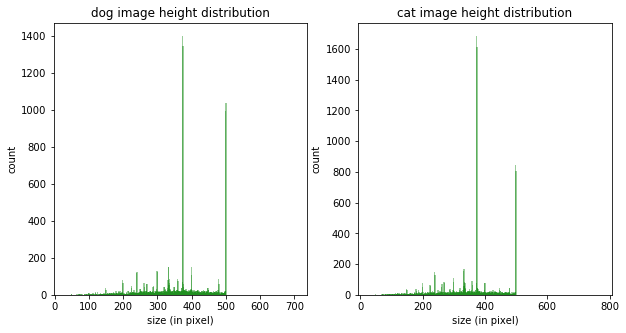


train sample count:  16000 
validation sample count:  4000 
test sample count:  5000
build model from pre-trainned model...
load pre-trainned model weight: VGG16
VGG16
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_4[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling

In [34]:
def flow_setup():
    
    one_hot_encoding_dict = label_one_hot_encoding(LABEL_LIST)
    print("label encoding is done.")
    
    
    raw_samples = load_samples(TRAIN_DATA_PATH_LIST, one_hot_encoding_dict)
    print("raw sample loaded.")
    
    image_shape_counter = raw_data_analysis(raw_samples, one_hot_encoding_dict)
    
    
    if DO_VISUALIZE:
        visualize_image_size_distribution(image_shape_counter)
    
    train_validation_samples, test_samples = train_test_split(raw_samples, test_size = 0.2, random_state = 42)
    train_samples, validation_samples = train_test_split(train_validation_samples, test_size = 0.2, random_state = 42)
    print()
    print("train sample count: ", len(train_samples), "\nvalidation sample count: ", len(validation_samples), "\ntest sample count: ", len(test_samples))
    #print("sample data example:\n", train_samples[random.randint(0, len(train_samples))])
    
    train_generator = sample_generator(train_samples, batch_size = 100)
    validation_generator = sample_generator(validation_samples, batch_size = 100)
    test_generator = sample_generator(test_samples, batch_size = 100)


    if RUN_HOMEBREW_MODEL:    
        print("build home brew model...")
        model_dict =  create_homebrew_models(input_shape = (224, 224, 3), num_classes = 2, output_activation_list = ['sigmoid', 'softmax'] , loss_function_list = ['categorical_crossentropy' ], optimizer_list = ["rmsprop", "adam"])
    else:
        print("build model from pre-trainned model...")
        model_dict = fine_tune_pretrained_model(num_classes = 2, pre_trained_model_list = ["VGG16","VGG19","ResNet"])

    print("model build finished.")    
    for name in model_dict.keys():
        model = model_dict[name]
        
        return
    
        print(name + " fitting started...")
        history_object = model.fit_generator(train_generator, samples_per_epoch= int(len(train_samples)), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=3, verbose=1)
        score = model.evaluate_generator(test_generator, 1500, max_q_size=10, nb_worker=1, pickle_safe=False)
        print(name + " score:", score)
        model.save("./models/" + name + ".h5" )
        print("model " + name + "saved.")
    

flow_setup()    